# CS4049 Assessment 2:

This assessment requires the use of a Taxi environment to train a model, using OpenAI. 

In [1]:
import gymnasium as gym  # For the environment.
import tensorflow as tf
import keras
import numpy as np
import random
import math
import matplotlib.pyplot as plt

print(tf.__version__)

2.14.0


__We can break down reinforcement learning into five simple steps:__

1. The agent is at state zero in an environment.
2. It will take an action based on a specific strategy.
3. It will receive a reward or punishment based on that action.
4. By learning from previous moves the the strategy of the agent becomes optimised. 
5. The process will repeat until an optimal strategy is found. 


The epsilon-greedy or $\epsilon$-greedy method balances the exploration of an environment with a probability $\epsilon \approx 10 \% $ and the exploitation of an environment, with probability $1-\epsilon$ at the same time. 

We start with a higher $\epsilon$, which reduces over time due to understanding the environment better.

## Tabular Method for the TaxiAgent:

In [ ]:
class TaxiAgent:
    def __init__(self, gamma: float = 0.95, alpha: float = 0.7, currentEpsilon: float = 1.0, decayFactor: float = 0.1):
        """An agent to be used for the taxi. This will keep track of the state of the taxi. This takes in 4 values, the gamma or the discount factor, the alpha or the learning rate, the current epsilon(the factor that controls the rate of exploration), and the decay factor which controls the rate at which the epsilon reduces."""
        self.env = gym.make('Taxi-v3')
        state_space = self.env.observation_space.n
        action_space = self.env.action_space.n
        print(state_space, action_space)
        self.quality_matrix = np.zeros((state_space, action_space))
        self.gamma = gamma
        self.alpha = alpha
        self.currentEpsilon = currentEpsilon
        self.minEpsilon = decayFactor
        self.reset()
        """ print(env.action_space.n) """
        """ print(f'Random action = {env.action_space.sample()} ') """
        """ print(observation) """

        pass

    def chooseAction(self, observation) -> int:
        """Choose the action based on the epsilon greedy principle."""
        greediness = random.uniform(0, 1)
        if greediness > self.currentEpsilon:
            # Agent has chosen to exploit the environment
            action = np.argmax(self.quality_matrix[observation])
        else:
            # Agent has chosen to explore the environment
            action = self.env.action_space.sample()
        return action

    def reset(self) -> None:
        """Resets the environment."""
        self.observation, self.info = self.env.reset()

    def updateQualityMatrix(self, action: int, old_obs: int, new_obs: int, reward) -> None:
        """Internally updates the QMatrix using the Bellman equation."""
        self.quality_matrix[old_obs][action] += self.alpha*(reward+(self.gamma*np.max(
            self.quality_matrix[new_obs]) - self.quality_matrix[old_obs][action]))

    def decayEpsilon(self, episode: int) -> None:
        """A function that changes the epsilon amount to be smaller, reflecting the decrease in exploration."""
        self.currentEpsilon = self.minEpsilon + \
            (1 - self.minEpsilon)*np.exp(-self.gamma*episode)

    def step(self, action) -> bool:
        """New step function using the QMatrix. Will output True if the environment is terminated or finishes."""
        new_obs, reward, terminated, truncated, info = self.env.step(action)
        self.updateQualityMatrix(action, self.observation, new_obs, reward)
        self.observation = new_obs
        return terminated or truncated

In [ ]:
def train(episodes: int, max_steps: int = 200):
    """The function to train the TaxiAgent."""
    agent = TaxiAgent()
    for episode in range(episodes):
        agent.reset()
        agent.decayEpsilon(episode)
        curr_step = 1
        done = False
        while curr_step < max_steps:
            action_to_take = agent.chooseAction(agent.observation)
            done = agent.step(action_to_take)
            curr_step += 1
            if done:
                break

    return agent


resulting_agent = train(2000, 200)

In [ ]:
def evaluate_agent(env: gym.Env, max_steps: int, numEvalEpisodes: int, Q: np.array):
    """This function evaluates the agent environment and outputs the mean reward and the standard deviation reward for the environment."""

    episode_rewards = []
    for episode in range(numEvalEpisodes):
        state, _ = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Take the action (index) that have the maximum reward
            action = np.argmax(Q[state])
            new_state, reward, done1, done2, info = env.step(action)
            total_rewards_ep += reward

            if done1 or done2:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward


mean_reward, std_reward = evaluate_agent(
    resulting_agent.env, 200, 1000, resulting_agent.quality_matrix)
print(f"Mean reward= {mean_reward:.2f} \n ± std of: {std_reward:.2f}")

In [ ]:
def watch_agent(env: gym.Env, max_steps: int, Q: np.array) -> None:
    """This is a visualising function for the environment."""
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    rewards = []
    for step in range(max_steps):
        # Take the action (index) that have the maximum reward
        action = np.argmax(Q[state])
        new_state, reward, done1, done2, info = env.step(action)
        total_rewards_ep += reward
        rewards.append(total_rewards_ep)

        if done1 or done2:
            break
        state = new_state


new_env = gym.make("Taxi-v3", render_mode="human")
watch_agent(new_env, 200, resulting_agent.quality_matrix)
new_env.close()

## Deep Q Learning Method for Taxi Agent:

A deep learning model uses multiple layers of a neural network to extract the abstract data from the input. 

The model is made up of 6 components:

- Environment
  - Reward
- Agent
  - Policy
  - Neural Network
- Replay Memory or Buffer


In [107]:
""" Have an agent class, with a policy. """
import tensorflow as tf

from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.agents.dqn import dqn_agent
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential, q_network
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy, py_epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.trajectories import TimeStep, Trajectory, trajectory, policy_step

In [108]:
""" Hyperparameters """
num_iterations = 10000
""" Learning rate """
ALPHA = 0.001 
""" Exploration-exploitation tradeoff """
EPSILON = 0.6 
"""Discount factor """

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 1000

batch_size = 1
""" The amount of times something is logged in the training loop. """
log_interval = 200

num_eval_episodes = 50
eval_interval = 1000
fc_layer_params = (60, 10)

In [109]:
""" Load the environment into TensorFlow. """
env_name = 'Taxi-v3'
env = gym.make(env_name)

ACTIONSIZE = env.action_space.n
OBSERVATIONSIZE = env.observation_space.n
print(ACTIONSIZE, OBSERVATIONSIZE)

env = suite_gym.load(env_name)
train_py_env = eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


# class RLAgent():
#   def __init__(self) -> None:
#     self.env_name = 'Taxi-v3'
#     """ self.env = gym.make('Taxi-v3') """
#     self.env = suite_gym.load(self.env_name)

#     train_py_env = suite_gym.load(self.env_name)
#     eval_py_env = suite_gym.load(self.env_name)
#     train_env = tf_py_environment.TFPyEnvironment(self.env_name)
#     train_env = tf_py_environment.TFPyEnvironment(self.env_name)
#     pass
#   def policy(self):
#     pass

6 500


In [110]:
""" Create the neural network. """
q_net = q_network.QNetwork(train_env.observation_spec(
), train_env.action_spec(), fc_layer_params=fc_layer_params)
q_net.create_variables()
q_net.summary()

Model: "QNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EncodingNetwork (EncodingN  multiple                  730       
 etwork)                                                         
                                                                 
 dense_84 (Dense)            multiple                  66        
                                                                 
Total params: 796 (3.11 KB)
Trainable params: 796 (3.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
""" Create the agent with the optimiser. """
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=ALPHA)

train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

""" print('Observation space:', train_env.observation_spec()) """
""" print('Action space:', train_env.action_spec()) """

""" print('Collect data spec observation:', agent.collect_data_spec.observation) """
""" print('Collect data spec action:', agent.collect_data_spec.action) """

agent.initialize()

In [112]:
""" Create policies. """
eval_policy = agent.policy
collect_policy = agent.collect_policy
epGreedyPolicy = py_epsilon_greedy_policy.EpsilonGreedyPolicy(
    agent.policy, epsilon=EPSILON, epsilon_decay_end_count=0.005, epsilon_decay_end_value=0.005)
print(
    f'Policies used are the {eval_policy.name} and the {collect_policy.name}.', )

print('Policy time_step_spec:', eval_policy.time_step_spec)
print('Policy action_spec:', eval_policy.action_spec)

Policies used are the greedy_policy and the epsilon_greedy_policy.
Policy time_step_spec: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(499)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Policy action_spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5))


In [113]:
def compute_avg_return(environment, policy, num_episodes=initial_collect_steps):
    """Computes the average return for a policy."""

    total_return = 0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


print(f'True Epsilon Greedy: average return = {compute_avg_return(eval_env, epGreedyPolicy, num_eval_episodes)}')
print(
    f'Evaluation policy: {eval_policy.name} average return = {compute_avg_return(eval_env, eval_policy, num_eval_episodes)}')
print(
    f'Data Collection Policy: {collect_policy.name} average return = {compute_avg_return(eval_env, collect_policy, num_eval_episodes)}')

True Epsilon Greedy: average return = -203.05999755859375


KeyboardInterrupt: 

In [ ]:
# Import the tf_uniform_replay_buffer module
from tf_agents.replay_buffers import tf_uniform_replay_buffer

# Create a TFUniformReplayBuffer instance
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    max_length=replay_buffer_max_length,
    batch_size=batch_size
)


# Create a ReplayBufferObserver instance
rb_observer = [replay_buffer.add_batch]

""" The driver should use the collect policy, or the training policy for exploration."""
driver = dynamic_step_driver.DynamicStepDriver(
    env=train_env,
    policy=epGreedyPolicy,
    observers=rb_observer,
    num_steps=1
)

""" Initial population of a buffer. """

for _ in range(1000):
    driver.run()

""" Convert the buffer into a dataset. """
dataset = replay_buffer.as_dataset(
    num_steps=2,
    num_parallel_calls=5,
    sample_batch_size=10).prefetch(3)


iterator = iter(dataset)

Agent will output loss every 200 steps.
Step: 0 	 , Loss: 0.01
Training loss hit 0.004804062657058239


ValueError: x and y must have same first dimension, but have shapes (200,) and (1,)

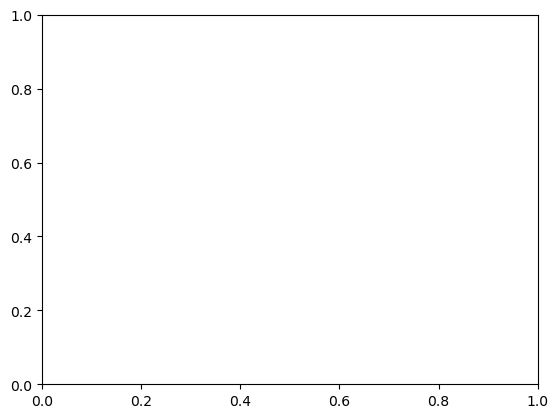

In [120]:
"""
For each episode do:
   1. Reset the environment and get the initial state.
   2. While the episode is not done:
       2.1. Agent chooses an action based on the current state.
       2.2. Perform the action in the environment.
       2.3. Receive the reward and the next state from the environment
       2.4. Store the experience (state, action, reward, next state) in the replay buffer
   3. Sample a batch of experiences from the replay buffer.
   4. Use the optimizer to update the agent's network parameters based on the sampled experiences.
5. Repeat steps 4 until the agent is sufficiently trained.
"""
losses = []
policies = [compute_avg_return(train_env, agent.policy, 10)]

agent.train_step_counter.assign(0)




print(f"Agent will output loss every {log_interval} steps.")

for _ in range(num_iterations):
    experience = next(iterator)
    train_loss = agent.train(experience[0]).loss
    """ if _ % 100 == 0:  # Print every 100 steps
    print(f'Step: {_} \t , Loss: {train_loss}') """
    if _ % log_interval == 0: 
        # print(
        #     f'Step: {_} \t , Loss: {train_loss}, Policy Measure: {compute_avg_return(train_env, agent.policy, 10)}')
        print(f'Step: {_} \t , Loss: {train_loss:.2f}')
        losses.append(train_loss)
        policies.append(compute_avg_return(train_env, driver.policy, 10))
    if train_loss < 0.005 or train_loss > 10000:
        print(f"Training loss hit {train_loss}")
        break

""" X = range(0, len(losses) * log_interval)
Y = losses
plt.plot(X, Y)
plt.ylim(top=550) """

print(losses)
print(policies)